In [1]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from nltk.tokenize import word_tokenize
from multiprocessing import Pool
from tqdm import tqdm

from keras_tqdm import TQDMNotebookCallback
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Bidirectional
from keras.layers.convolutional import Convolution1D, MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
import h5py

%matplotlib inline

Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: Tesla K80 (CNMeM is enabled with initial size: 95.0% of memory, cuDNN 5110)


In [5]:
def clean_tweets(tweets):
    # takes a list of tweets and outputs cleaned tweets list

    cleaned_tweets = []

    for tweet in tweets:
        tweet_temp = " ".join(tweet.split())  # strip duplicate whitespace
        tweet_temp = re.sub("\.{4,}", "...", tweet_temp)  # replace multiple ..... with ...
        tweet_temp = re.sub(r"^https?://.*[\r\n]*", "", tweet_temp)  # strip URLs
        tweet_temp = re.sub(r"[@#$%^&*~]", "", tweet_temp)  # remove some weird characters
        tweet_temp = tweet_temp.lower()  # to lowercase
        """ replace 3+ consecutive occurrences of a char by "n" chars to preserve 'excitement' (watch out with that!)
        since it might change the vocabulary for words such as 'too' etc."""
        matches = re.findall(r"((\w)\2{2,})", tweet_temp)
        n = 2
        if matches is not None:
            for match in matches:
                tweet_temp = re.sub(match[0], match[1]*n, tweet_temp)
        cleaned_tweets.append(tweet_temp)

    return cleaned_tweets


def tokenize_tweets(tweets, n_cores=8):
    # Tokenize tweets using multiple CPU cores if needed

    tokenized_tweets = []

    bar = tqdm(total=len(cleaned_tweets))
    pool = Pool(processes=n_cores, maxtasksperchild=1)
    for text in pool.imap(word_tokenize, tweets, chunksize=10000):
        tokenized_tweets.append(text)
        bar.update()

    return tokenized_tweets


def get_words(tweets):
    # Concatenate all tweets into one huge list of words (needed for word freq counts)

    all_words = []
    for tweet in tweets:
        for word in tweet:
            all_words.append(word)

    return all_words


def build_dataset(words, vocabulary_size, unk_label=0):
    # Build dictionary of word -> order of frequency

    count = [["UNK", -1]]
    count.extend(Counter(words).most_common(vocabulary_size - 1))
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)
    data = list()
    unk_count = 0
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = unk_label  # dictionary["UNK"]
            unk_count += 1
        data.append(index)
    count[0][1] = unk_count
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return data, count, dictionary, reverse_dictionary


def tweet_to_int(tweet, dictionary, unk_label=0):
    # Map a tweet to integers based on supplied dictionary

    tweet_int = []
    unk_count = 0

    for word in tweet:
        if word in dictionary:
            idx = dictionary[word]
        else:
            idx = unk_label
            unk_count += 1
        tweet_int.append(idx)

    return tweet_int

In [6]:
# Load data
twitter = pd.read_csv("/home/slazien/Downloads/Sentiment_Analysis_Dataset.csv",
                      error_bad_lines=False, encoding="utf-8")

tweets = twitter["SentimentText"]
sent = twitter["Sentiment"]

Skipping line 8836: expected 4 fields, saw 5

Skipping line 535882: expected 4 fields, saw 7



In [7]:
# Clean text
cleaned_tweets = clean_tweets(tweets)

# Tokenize tweets
tokenized_tweets = tokenize_tweets(cleaned_tweets, n_cores=6)

# Transform tweets into a list of words
words = get_words(tokenized_tweets)

 99%|█████████▉| 1570001/1578612 [01:04<00:00, 20408.78it/s]

In [8]:
# Finally, prepare data for the model
# vocab_size = int(0.01*len(words))  # take 10% of all words in the tweets
vocab_size = 100000

# Set unknown label to -1 instead of 0 since keras uses 0 to pad sequences
data, count, dictionary, reverse_dictionary = build_dataset(words, vocab_size, unk_label=0)
del data

# Transform tweets to format accepted by LSTM
X = []
X_lengths = []
for tweet in tokenized_tweets:
    mapping = tweet_to_int(tweet, dictionary, unk_label=0)
    X.append(mapping)
    X_lengths.append(len(mapping))
X = np.asarray(X)
y = np.asarray(sent)

# Split data intro training and validation
seed = 42
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=seed)

# Truncate and pad input sequences
max_seq_len = max(X_lengths)
X_train = sequence.pad_sequences(X_train, maxlen=max_seq_len)
X_val = sequence.pad_sequences(X_val, maxlen=max_seq_len)

100%|██████████| 1578612/1578612 [01:21<00:00, 20408.78it/s]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 229, 16)           1600000   
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 229, 32)           1568      
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 114, 32)           0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dropout_5 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 101       
Total params: 1,654,869.0
Trainable params: 1,654,869.0
Non-trainable params: 0.0
____________________________________________________________

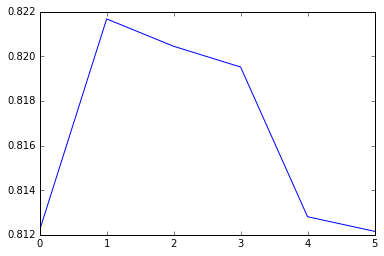

In [10]:
# Define and train the model, yay! :D
embed_vec_len = 16
train_n = len(X_train)

# Set up checkpoints
filepath = "weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpointer = ModelCheckpoint(filepath="./model_checkpoints/" + filepath, 
                               monitor="val_acc", verbose=1, save_best_only=True, mode="max")

# Perform early stopping
early_stopper = EarlyStopping(monitor="val_lo", min_delta=0.01, 
                             patience=3, verbose=1)

callbacks_list = [checkpointer, early_stopper]

model = Sequential()
model.add(Embedding(vocab_size, embed_vec_len, input_length=max_seq_len))
model.add(Convolution1D(filters=32, kernel_size=3, padding="same", activation="relu"))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(100))
model.add(Dropout(0.5))
model.add(Dense(1, activation="sigmoid"))
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
print(model.summary())
history = model.fit(X_train[:train_n], y_train[:train_n], epochs=100, batch_size=256, validation_split=0.2,
                   verbose=1, callbacks=callbacks_list)
plt.plot(history.history["val_acc"])
model_eval = model.evaluate(X_val, y_val)

In [10]:
vocab_size = 100000
embed_vec_len = 16
model = Sequential()
model.add(Embedding(vocab_size, embed_vec_len, input_length=max_seq_len))
model.add(Convolution1D(filters=32, kernel_size=3, padding="same", activation="relu"))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(100))
model.add(Dropout(0.5))
model.add(Dense(1, activation="sigmoid"))

In [11]:
model.load_weights("./model_checkpoints/weights-improvement-01-0.82.hdf5")

In [14]:
model.predict(X_train[0:100]) > 0.5

array([[ True],
       [ True],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [False],
       [ True],
       [ True],
       [ True],
       [False],
       [ True],
       [False],
       [ True],
       [ True],
       [ True],
       [False],
       [ True],
       [ True],
       [False],
       [False],
       [False],
       [ True],
       [ True],
       [ True],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [ True],
       [ True],
       [False],
       [ True],
       [ True],
       [False],
       [False],
       [ True],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [ True],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [